# Tarea 3: Evaluación de Segmentación


### Funciones de Carga y Visualización

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import graph, segmentation, metrics
from skimage.metrics import adapted_rand_error, variation_of_information
import os
import re

# Set directory paths
dataset_dir = "../dataset/malignant/"

# Function to extract numbers from filenames like "malignant (2).png"
def extract_number(filename):
    match = re.search(r"\((\d+)\)", filename)  # Extracts number inside parentheses
    return int(match.group(1)) if match else float('inf')  # Returns large number if no match

# ✅ Sort image files numerically instead of alphabetically
image_files = sorted(
    [f for f in os.listdir(dataset_dir) if f.endswith(".png") and not "_mask" in f],
    key=extract_number  # Sort based on extracted number
)

ground_truth_files = sorted(
    [f for f in os.listdir(dataset_dir) if f.endswith("_mask.png")],
    key=extract_number  # Sort based on extracted number
)

# ✅ Find index of "malignant (1).png"
start_index = next((i for i, f in enumerate(image_files) if f == "malignant (2).png"), None)

# ✅ Start processing from "malignant (2).png"
if start_index is not None:
    image_files = image_files[start_index:start_index + 5]  # Process 5 images in numerical order
    ground_truth_files = ground_truth_files[start_index:start_index + 5]
else:
    print("Error: malignant (2).png not found in dataset directory!")
    exit()



# Keep only the first 5 images
image_files = image_files[:5]
ground_truth_files = ground_truth_files[:5]

# Define thresholds
threshold_split =10  # Lower values give finer splits
threshold_merge =5  # Controls similarity for merging

# Initialize lists to store metric results
iou_scores, dice_scores, accuracy_scores, rand_index_scores, vi_scores = [], [], [], [], []


### Definir la funcion Split

In [2]:
def split(image, x, y, width, height, threshold):
    """ Recursively split an image using a quadtree approach based on variance. """
    if width < 2 or height < 2:  
        return [(x, y, width, height)]  # Stop splitting if region is too small

    region = image[y:y+height, x:x+width]
    mean, std = np.mean(region), np.std(region)  # Compute mean and standard deviation

    if std < threshold:  
        return [(x, y, width, height)]  # Stop if region is homogeneous

    # Split into four quadrants
    half_w, half_h = width // 2, height // 2
    regions = []
    regions += split(image, x, y, half_w, half_h, threshold)            # Top-left
    regions += split(image, x + half_w, y, half_w, half_h, threshold)    # Top-right
    regions += split(image, x, y + half_h, half_w, half_h, threshold)    # Bottom-left
    regions += split(image, x + half_w, y + half_h, half_w, half_h, threshold)  # Bottom-right

    return regions


### Definir la funcion Merge

In [3]:
import numpy as np
from skimage import graph, segmentation
import networkx as nx

def merge(image, regions, threshold):
    """Merge regions using RAG with custom hierarchical merging, corrected progress display."""
    labels = segmentation.slic(image, compactness=10, n_segments=len(regions), start_label=1, channel_axis=None)
    rag = graph.rag_mean_color(image, labels)

    for node in rag.nodes:
        rag.nodes[node]['mean color'] = {'mean': float(np.mean(image[labels == node]))}

    def weight_func(rag, src, dst):
        return abs(rag.nodes[src]['mean color']['mean'] - rag.nodes[dst]['mean color']['mean'])

    total_nodes = rag.number_of_nodes()  # Total number of nodes at the start
    nodes_processed = 0

    while rag.number_of_edges() > 0 and rag.number_of_nodes() > 1:
        min_weight = float('inf')
        merge_pair = None

        for u, v in rag.edges:
            weight = weight_func(rag, u, v)
            if weight < min_weight:
                min_weight = weight
                merge_pair = (u, v)

        if min_weight > threshold or merge_pair is None:
            break

        src, dst = merge_pair

        src_mean = rag.nodes[src]['mean color']['mean']
        dst_mean = rag.nodes[dst]['mean color']['mean']
        new_mean = (src_mean + dst_mean) / 2
        rag.nodes[dst]['mean color']['mean'] = new_mean

        labels[labels == src] = dst

        for neighbor in list(rag.neighbors(src)):
            if neighbor != dst:
                try:
                    edge_data = rag.edges[dst, neighbor].copy() if rag.has_edge(dst, neighbor) else rag.edges[neighbor,dst].copy()
                    rag.add_edge(dst, neighbor, **edge_data)
                except KeyError:
                    try:
                        edge_data = rag.edges[neighbor, src].copy()
                        rag.add_edge(neighbor, dst, **edge_data)
                    except KeyError:
                        pass

        rag.remove_node(src)
        nodes_processed += 1  # Increment the node counter

        progress_percentage = (nodes_processed / total_nodes) * 100 if total_nodes > 0 else 0
        print(f"Merge Progress: {progress_percentage:.2f}%", end="\r")

    print()

    unique_labels = np.unique(labels)
    label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
    remapped_labels = np.vectorize(label_map.get)(labels)

    return remapped_labels

Aplicar Split and Merge a las Imagenes

In [4]:
def compute_segmentation_metrics(segmentation, ground_truth):
    """ Compute segmentation evaluation metrics. """

    # Convert to binary masks if necessary
    segmentation = segmentation > 0
    ground_truth = ground_truth > 0

    # Compute Jaccard Index (IoU)
    intersection = np.logical_and(segmentation, ground_truth)
    union = np.logical_or(segmentation, ground_truth)
    iou = np.sum(intersection) / np.sum(union)

    # Compute Dice Coefficient (F1-Score)
    dice = 2 * np.sum(intersection) / (np.sum(segmentation) + np.sum(ground_truth))

    # Compute Pixel Accuracy
    accuracy = np.sum(segmentation == ground_truth) / ground_truth.size

    # Compute Rand Index
    rand_error, _, _ = adapted_rand_error(ground_truth, segmentation)

    # Compute Variation of Information
    vi_split, vi_merge = variation_of_information(ground_truth, segmentation)

    return iou, dice, accuracy, 1 - rand_error, (vi_split, vi_merge)


### Imprimir imagenes con su segmentacion


Processing: malignant (2).png...
Merge Progress: 76.51%


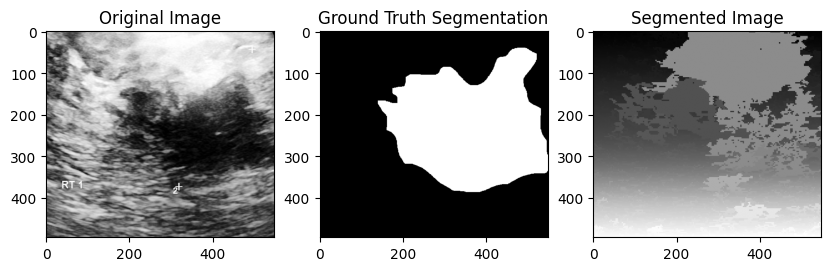


Processing: malignant (3).png...
Merge Progress: 91.38%


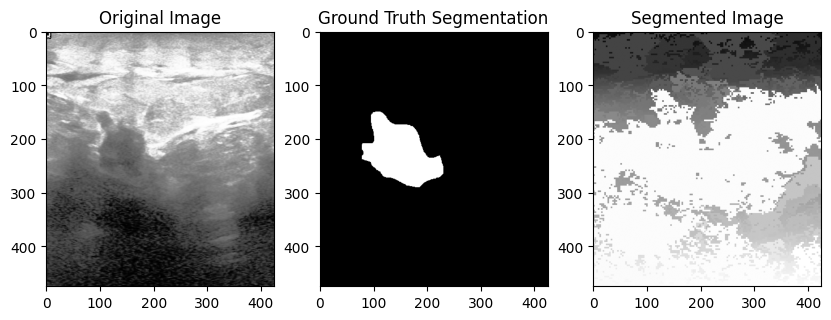


Processing: malignant (4).png...
Merge Progress: 98.15%


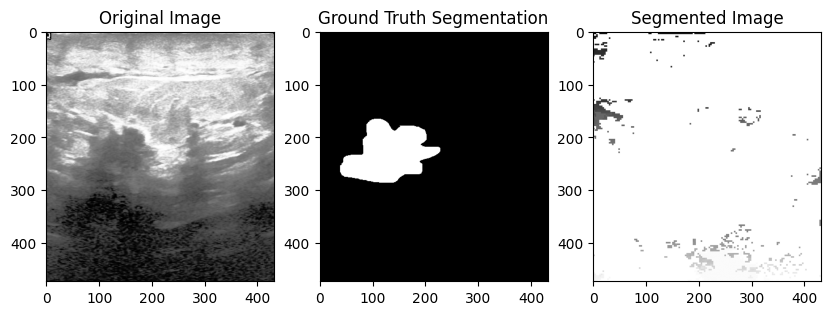


Processing: malignant (5).png...
Merge Progress: 91.18%


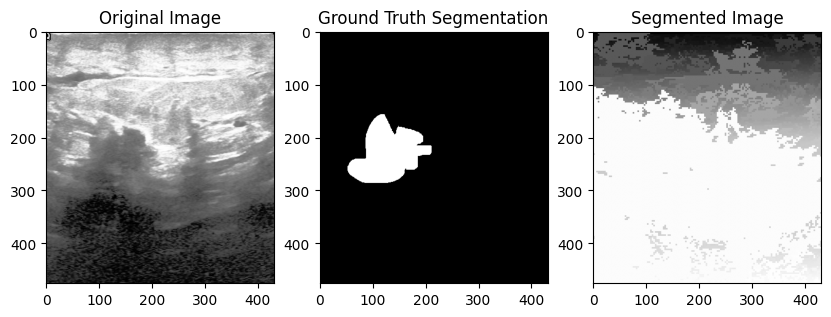


Processing: malignant (6).png...
Merge Progress: 87.53%


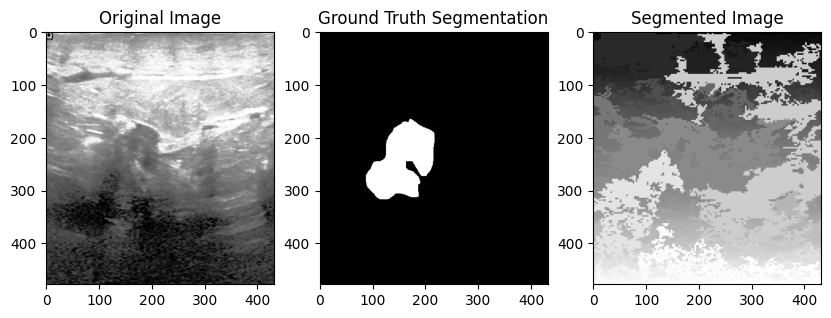


--- Métricas promedio para todas las imágenes ---
✅ Índice de Jaccard (IoU) promedio: 0.1177
✅ Coeficiente de Dice (F1-Score) promedio: 0.1948
✅ Precisión de píxeles promedio: 0.1177
✅ Índice de Rand adaptado promedio: 1.0000
✅ Variación de la información (VI) promedio: División = 0.0008, Fusión = 0.4526


In [5]:
for img_file, gt_file in zip(image_files, ground_truth_files):
    print(f"\nProcessing: {img_file}...")

    original_image = cv2.imread(os.path.join(dataset_dir, img_file), cv2.IMREAD_GRAYSCALE)
    ground_truth = cv2.imread(os.path.join(dataset_dir, gt_file), cv2.IMREAD_GRAYSCALE)

    original_image = cv2.equalizeHist(original_image)  # Normalizar

    regions = split(original_image, 0, 0, original_image.shape[1], original_image.shape[0], threshold_split)
    segmented_image = merge(original_image, regions, threshold_merge)

    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Image")

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth, cmap='gray')
    plt.title("Ground Truth Segmentation")

    # Segmented image
    plt.subplot(1, 3, 3)
    plt.imshow(segmented_image, cmap='gray')
    plt.title("Segmented Image")

    plt.show()

    iou, dice, accuracy, rand_index, vi = compute_segmentation_metrics(segmented_image, ground_truth)

    iou_scores.append(iou)
    dice_scores.append(dice)
    accuracy_scores.append(accuracy)
    rand_index_scores.append(rand_index)
    vi_scores.append(vi)

# Calcular y mostrar promedios *después* del bucle
avg_iou = np.mean(iou_scores)
avg_dice = np.mean(dice_scores)
avg_accuracy = np.mean(accuracy_scores)
avg_rand_index = np.mean(rand_index_scores)
avg_vi_split = np.mean([vi[0] for vi in vi_scores])
avg_vi_merge = np.mean([vi[1] for vi in vi_scores])

print("\n--- Métricas promedio para todas las imágenes ---")
print(f"✅ Índice de Jaccard (IoU) promedio: {avg_iou:.4f}")
print(f"✅ Coeficiente de Dice (F1-Score) promedio: {avg_dice:.4f}")
print(f"✅ Precisión de píxeles promedio: {avg_accuracy:.4f}")
print(f"✅ Índice de Rand adaptado promedio: {avg_rand_index:.4f}")
print(f"✅ Variación de la información (VI) promedio: Split = {avg_vi_split:.4f}, Merge = {avg_vi_merge:.4f}")

Las métricas obtenidas indican un rendimiento de segmentación deficiente en general, con un problema principal en la etapa merge. Vamos a analizarlas en detalle:

* **Índice de Jaccard (IoU) promedio: 0.1177:** Este valor, que mide la superposición entre la segmentación predicha y la ground truth, es muy bajo. Indica que hay muy poca coincidencia entre las regiones segmentadas y las reales. Un valor ideal sería cercano a 1.

* **Coeficiente de Dice (F1-Score) promedio: 0.1948:** Similar al IoU, este valor también es bajo, lo que refuerza la conclusión de que la segmentación no está capturando bien las regiones reales. Un valor ideal sería cercano a 1.

* **Precisión de píxeles promedio: 0.1177:** Este valor indica que solo el 11.77% de los píxeles fueron clasificados correctamente. Es un valor muy bajo y consistente con los otros dos.

* **Variación de la información (VI) promedio: Split = 0.0008, Merge = 0.4526:** Aquí tenemos dos valores importantes:

    * **VI (División):** Un valor extremadamente bajo (0.0008) sugiere que la división inicial de la imagen en regiones funciona muy bien. Las regiones generadas por tu algoritmo de división son muy consistentes con la ground truth a un nivel muy fino.

    * **VI (Merge):** Un valor moderado (0.4526) indica que el proceso merge tiene problemas. Si bien no es un valor altísimo, sugiere que la fusión no está combinando las regiones de manera precisa, lo que lleva a las discrepancias entre la segmentación y la ground truth.

**En resumen:** La división inicial parece ser muy efectiva, pero la fusión es la que está causando los problemas. Los bajos valores de IoU, Dice y precisión de píxeles, junto con el valor moderado de VI merge, apuntan a que la estrategia merge necesita mejoras significativas.

**Posibles mejoras:**

* **Revisar la lógica merge:** Analizar cuidadosamente la función merge. ¿Se estan fusionando regiones que no deberían unirse? 

* **Considerar umbrales:** Experimentar con diferentes umbrales para la fusión. Un umbral más alto requerirá mayor similitud entre regiones para que se fusionen, lo que podría mejorar la precisión, pero también podría dejar regiones sin fusionar.

* **Visualizar el proceso merge:** Intentar visualizar la imagen después de cada paso merge para entender mejor cómo se están combinando las regiones y dónde se producen los errores.

* **Simplificar la lógica merge (para pruebas):** Para aislar el problema, puedes probar con una lógica merge más sencilla y ver si los resultados mejoran.
